<a href="https://colab.research.google.com/github/3ndung/NLP_CLASSIFICATION_LSTM_SIMPLE/blob/main/3000_08_04_2023_RNN_BASIC_MULTICLASIFICATION_NLP_NLTK_TYO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import library 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np



Update adding feature callbacks : Untuk mengambil weight/bobot terbaik saat training yang berfungsi mempercepat waktu pembelajaran dengan last point step adalah weight terbaik.

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Cek TF Version

In [4]:
print(tf.__version__)

2.12.0


# Download dataset dari data yang sudah dibersihkan 

In [5]:
dataset_dir = os.path.join(os.path.dirname('dataset'), '/content/drive/MyDrive/TYO_NLTK/DTS3000/')

## Melihat directory dataset

In [6]:
os.listdir(dataset_dir)

['TRAIN', 'TEST']

## SET DATA UNTUK DI TRAIN 

In [7]:
train_dir = os.path.join(dataset_dir, 'TRAIN')
os.listdir(train_dir)

['EKO', 'HEL', 'OLA', 'POL']

## SET DATA UNTUK DI TEST

In [8]:
test_dir = os.path.join(dataset_dir, 'TEST')
os.listdir(train_dir)

['EKO', 'HEL', 'OLA', 'POL']

## Sampling data yang akan di Training 

In [9]:
sample_file = os.path.join(train_dir, 'EKO/109.txt')

with open(sample_file) as f:
  print(f.read())

menaker pastikan ump 2023 naik sesuai tuntutan buruh


tf.keras.utils.text_dataset_from_directory adalah sebuah fungsi yang disediakan oleh TensorFlow yang digunakan untuk memuat data teks dari direktori pada sistem file. Fungsi ini membantu dalam mempersiapkan data dalam bentuk yang sesuai untuk pemrosesan menggunakan model pembelajaran mesin.

Fungsi ini dapat membaca semua file teks dalam direktori tertentu dan mengorganisasikannya ke dalam dua set data, yaitu data latih dan data validasi, dengan pembagian data yang dapat dikonfigurasi oleh pengguna. Fungsi ini juga dapat menghasilkan sebuah objek tf.data.Dataset yang dapat digunakan untuk memasukkan data ke dalam model pembelajaran mesin.

Pengguna dapat menentukan parameter seperti batch_size, seed, validation_split, subset, labels, dan sebagainya untuk mengatur bagaimana data akan dibagi dan disiapkan untuk model.

Dalam keseluruhan, fungsi tf.keras.utils.text_dataset_from_directory sangat berguna bagi para pengembang dan peneliti yang bekerja dengan pemrosesan bahasa alami dan ingin mempersiapkan data teks dalam format yang sesuai untuk diproses dengan model pembelajaran mesin.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/TYO_NLTK/DTS3000/TRAIN', 
    batch_size=batch_size, 
    validation_split=0.2, # Parto law 80:20
    subset='training', # ini digunakan untuk data yang akan di training
    seed=seed)

Found 2400 files belonging to 4 classes.
Using 1920 files for training.


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'jelang persaingan panas perebutan titel juara dunia di motogp valencia 2022 fabio quartararo justru santai'
Label 2
Review b'ojk potensi kredit bermasalah terus meningkat seiring dampak pandemi pada ekonomi'
Label 0
Review b'penyakit kanker terkait gen dipengaruhi faktor lingkungan'
Label 1


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to EKO
Label 1 corresponds to HEL
Label 2 corresponds to OLA
Label 3 corresponds to POL


In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/TYO_NLTK/DTS3000/TRAIN', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 2400 files belonging to 4 classes.
Using 480 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/TYO_NLTK/DTS3000/TEST', 
    batch_size=batch_size)

Found 604 files belonging to 4 classes.


## Membuat function untuk menstandarkan/ menseragamkan string input

In [15]:
def custom_standardization(input_data):
  # Membuat Semua String menjadi Lower String/ huruf kecil Semua
  lowercase = tf.strings.lower(input_data)
  # Menghapus apabila ada html tag
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

## [TEXTVECTORIZATION](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

Adalah pre-processing sebelum proses pembelajaran yang mengubah string mentah kedalam bentuk intger yang dapat dibaca oleh lapisan berikutnya dalam Synapsis/ Layer berikutnya contoh embeding dan denses


In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    # Memanggil fungsi sebelumnya yang mestandarkan semua string input menjadi lower case dan menghilangkan tag html bila ada
    standardize=custom_standardization,
    # Memberikan batasan padding agar panjang matrix sama pada setiap masukan.
    max_tokens=max_features,
    # Output String akan diubah menjadi bentuk integer
    output_mode='int',
    output_sequence_length=sequence_length)

'''
Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.
'''

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)




# Fungsi yang mengubah setiap string text input ke dalam bentuk intger dan menyimpan dalam array, dengan menggunakan vectorize_layer yang telah diset diatas.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[13], label_batch[13]
print("\nReview -> text_batch[13]", first_review)
print("Label -> Label_batch[13]", raw_train_ds.class_names[first_label])
print("\nVectorized review nya seperti ini \n\n", vectorize_text(first_review, first_label))


Review -> text_batch[13] tf.Tensor(b'studi olahraga teratur menjaga kesehatan otak pada orang tua', shape=(), dtype=string)
Label -> Label_batch[13] HEL

Vectorized review nya seperti ini 

 (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 63,  86, 869, 304,  11, 302,  18, 156, 861,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  

## Pembuktian Terbalik TEXTVECTORIZATION

In [20]:
print("119 ---> ",vectorize_layer.get_vocabulary()[119])
print("395 ---> ",vectorize_layer.get_vocabulary()[395])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

119 --->  emas
395 --->  kelebihan
Vocabulary size: 4740


# Menggubah semua input train, validasi dan test kedalam bentuk integer

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
# Tunning dataset train, validasi dan test dengan AUTOTUNE untuk optimisasi shape data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Layer embedding dimension kita set menjadi 16 , seperti yang sering digunakan dalam panduan, embedding ini hanya dapat digunakan pada integer positiv dan untuk memperbaiki matrix.

In [23]:
embedding_dim = 16

## RNN MODEL 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

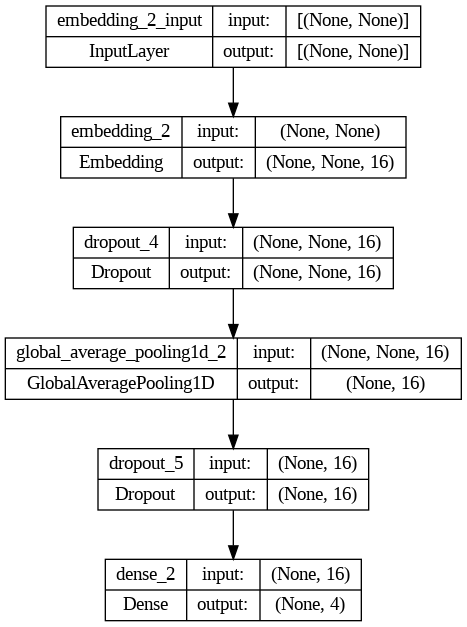

In [32]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()



img_file = 'model_arch.png'
tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

In [ ]:
#model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
#              optimizer='adam',
#              metrics=tf.metrics.Accuracy())




In [33]:
model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])

In [34]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath='BEST_AJA.h5',save_best_only=True, save_weights_only=True)

In [35]:
epochs = 150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint])

Epoch 1/150
60/60 [==============================] - 128s 2s/step - loss: 1.3869 - accuracy: 0.2453 - val_loss: 1.3845 - val_accuracy: 0.2479
Epoch 2/150
60/60 [==============================] - 0s 8ms/step - loss: 1.3847 - accuracy: 0.2995 - val_loss: 1.3847 - val_accuracy: 0.2375
Epoch 3/150
60/60 [==============================] - 0s 8ms/step - loss: 1.3827 - accuracy: 0.3026 - val_loss: 1.3840 - val_accuracy: 0.2333
Epoch 4/150
60/60 [==============================] - 0s 8ms/step - loss: 1.3806 - accuracy: 0.2953 - val_loss: 1.3831 - val_accuracy: 0.2062
Epoch 5/150
60/60 [==============================] - 0s 8ms/step - loss: 1.3783 - accuracy: 0.2839 - val_loss: 1.3811 - val_accuracy: 0.2083
Epoch 6/150
60/60 [==============================] - 0s 8ms/step - loss: 1.3752 - accuracy: 0.3156 - val_loss: 1.3786 - val_accuracy: 0.2271
Epoch 7/150
60/60 [==============================] - 1s 8ms/step - loss: 1.3719 - accuracy: 0.3422 - val_loss: 1.3753 - val_accuracy: 0.3167
Epoch 8/150


In [37]:
model.save('/content/drive/MyDrive/NLP_MODEL/TYO_06_3000_DATASET_MODEL.h5')

In [36]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

19/19 [==============================] - 207s 6s/step - loss: 0.2619 - accuracy: 0.9338
Loss:  0.2619323432445526
Accuracy:  0.9337748289108276


In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

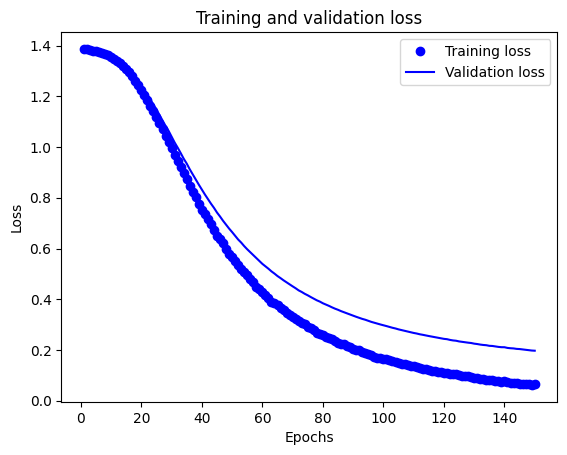

In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

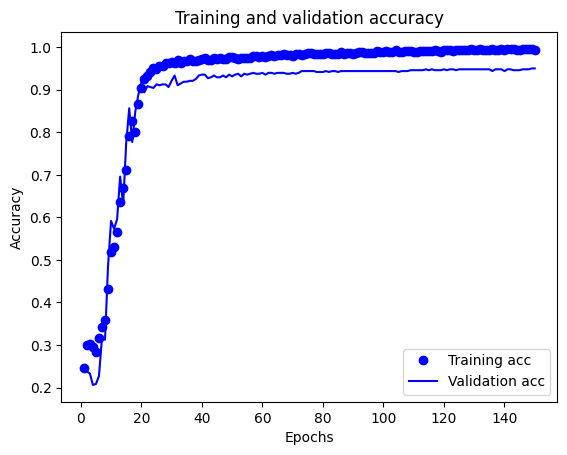

In [40]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [41]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])
export_model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])



# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 1s 19ms/step - loss: 0.2619 - accuracy: 0.9338
0.9337748289108276


In [42]:
['EKO', 'HEL', 'OLA','POL']

['EKO', 'HEL', 'OLA', 'POL']

# PREDIKSI

In [51]:
examples = ["MotoGP 2015 akan dikenang sebagai salah satu yang paling sengit dalam gelaran kejuaraan dunia balap motor grand prix",
            "Ida Fauziyah menargetkan penyaluran Ekonomi Bantuan Subsidi Upah (BSU) atau BLT Gaji melalui PT Pos",
            "Teknik Dasar Jalan Cepat, Sejarah, dan Manfaat untuk Kesehatan",
            "Covid-19 akan meningkat apabila masayarakat tidak patuh protokol kesehatan",
            "Rencana Impor KRL Bekas Didukung Erick Thohir, tetapi belum mendapat persetujuan kementrian perdagangan & Ekonomi",
            "Inflasi Indonesia Naik Lagi pada Februari 2023",
            "Pemilu 2024 diikuti oleh 4 partai politik"]


#for x in examples:
export_model.predict(examples)


1/1 [==============================] - 0s 39ms/step


array([[1.2988556e-03, 4.0394883e-03, 9.9150425e-01, 3.1573784e-03],
       [9.8996603e-01, 5.1066256e-03, 6.1889336e-04, 4.3084547e-03],
       [9.3373150e-02, 8.5145521e-01, 2.6556874e-02, 2.8614752e-02],
       [6.5978013e-02, 9.0833724e-01, 1.1885913e-02, 1.3798871e-02],
       [9.6798360e-01, 1.6913534e-03, 4.1803569e-04, 2.9907037e-02],
       [9.3336272e-01, 4.2850379e-02, 1.3743513e-02, 1.0043364e-02],
       [3.0783596e-03, 9.8156033e-04, 3.4801776e-03, 9.9245995e-01]],
      dtype=float32)

In [46]:
#the_winner = np.argmax(export_model.predict(examples))
#print(f'Prediksi Terbesar {the_winner}')

# FUNGSI UNTUK MEMBUAT VISUALISASI GRAFIK PIE CHART

In [49]:
def Pie_Chart_Visualization(x):

          # Pie chart, where the slices will be ordered and plotted counter-clockwise:
          labels = ['EKO', 'HEL', 'OLA', 'POL']
          sizes = export_model.predict(examples)[x].tolist()
     

          explode = (0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

          fig1, ax1 = plt.subplots()
          ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                  shadow=True, startangle=90)
          ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

          plt.show()

def Winner(x):

          winner = np.argmax(export_model.predict(examples)[x])

          if winner == 0:
            print('Best Prediction Adalah : Ekonomi \n')
          elif winner == 1:
            print('Best Prediction Adalah : Kesehatan \n')
          elif winner == 2:
            print('Best Prediction Adalah : Olahraga \n')            
          else :
            print('Best Prediction Adalah : Politik \n')          

# PENGUJIAN PROSENATASE PREDIKSI DALAM BENTUK GRAFIK DARI DATA SAMPLE

'MotoGP 2015 akan dikenang sebagai salah satu yang paling sengit dalam gelaran kejuaraan dunia balap motor grand prix'

1/1 [==============================] - 0s 39ms/step


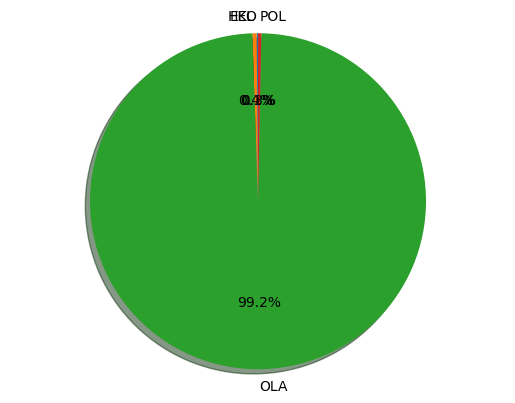

None

1/1 [==============================] - 0s 45ms/step
Best Prediction Adalah : Olahraga 



'Ida Fauziyah menargetkan penyaluran Ekonomi Bantuan Subsidi Upah (BSU) atau BLT Gaji melalui PT Pos'

1/1 [==============================] - 0s 40ms/step


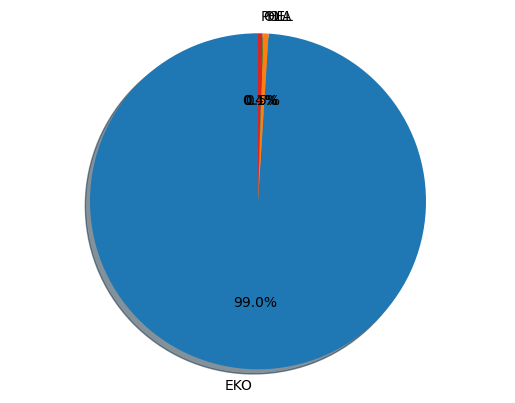

None

1/1 [==============================] - 0s 51ms/step
Best Prediction Adalah : Ekonomi 



'Teknik Dasar Jalan Cepat, Sejarah, dan Manfaat untuk Kesehatan'

1/1 [==============================] - 0s 43ms/step


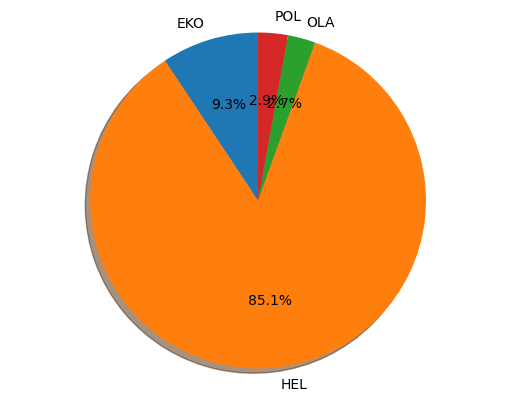

None

1/1 [==============================] - 0s 42ms/step
Best Prediction Adalah : Kesehatan 



'Covid-19 akan meningkat apabila masayarakat tidak patuh protokol kesehatan'

1/1 [==============================] - 0s 38ms/step


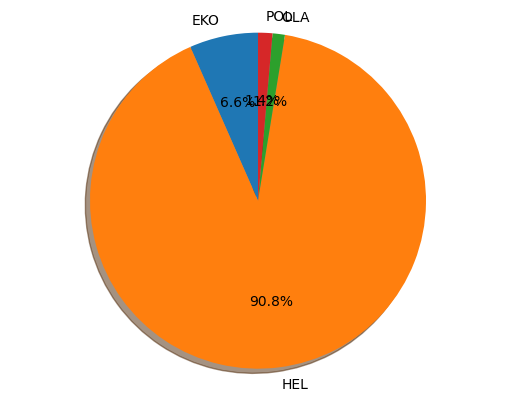

None

1/1 [==============================] - 0s 41ms/step
Best Prediction Adalah : Kesehatan 



'Rencana Impor KRL Bekas Didukung Erick Thohir, tetapi belum mendapat persetujuan kementrian perdagangan & Ekonomi'

1/1 [==============================] - 0s 39ms/step


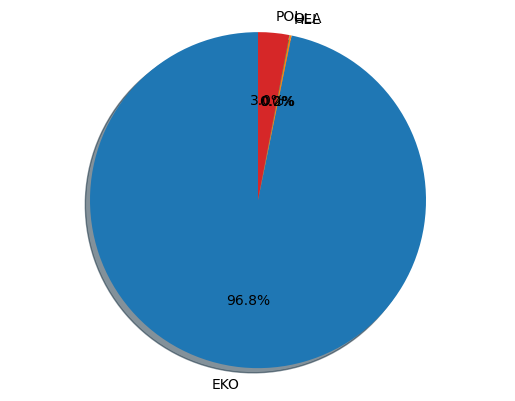

None

1/1 [==============================] - 0s 39ms/step
Best Prediction Adalah : Ekonomi 



'Inflasi Indonesia Naik Lagi pada Februari 2023'

1/1 [==============================] - 0s 39ms/step


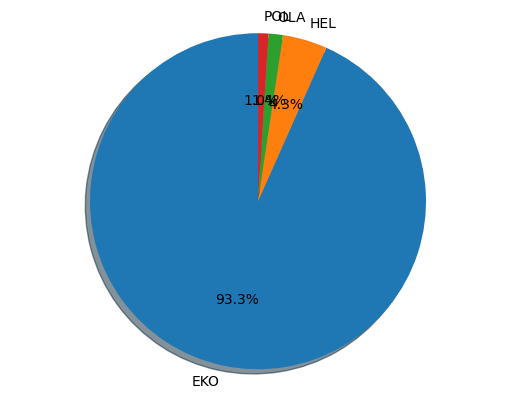

None

1/1 [==============================] - 0s 69ms/step
Best Prediction Adalah : Ekonomi 



'Pemilu 2024 diikuti oleh 4 partai politik'

1/1 [==============================] - 0s 65ms/step


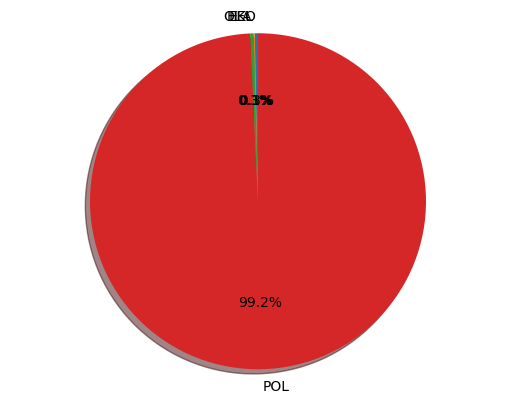

None

1/1 [==============================] - 0s 54ms/step
Best Prediction Adalah : Politik 



In [52]:
for x in range(len(examples)):
  display(examples[x])
  display(Pie_Chart_Visualization(x))
  Winner(x)

# CONFUSION MATRIX SEBAGAI TAMBAHAN PENDUKUNG UNTUK MEPERJELAS VISUALISASI DIATAS

# CONFUSION MATRIX WITH SKLEARN DARI DATA EXAMPLE PREDIKSI DIATAS

In [53]:
KNOWLDEGE = '''
examples = ["MotoGP 2015 akan dikenang sebagai salah satu yang paling sengit dalam gelaran kejuaraan dunia balap motor grand prix",
            "Ida Fauziyah menargetkan penyaluran Bantuan Subsidi Upah (BSU) atau BLT Gaji melalui PT Pos",
            "Teknik Dasar Jalan Cepat, Sejarah, dan Manfaat untuk Kesehatan",
            "Covid-19 akan meningkat apabila masayarakat tidak patuh protokol kesehatan",
            "Rencana Impor KRL Bekas: Didukung Erick Thohir, Belum Direstui Kemenperin",
            "Inflasi Indonesia Naik Lagi pada Februari 2023"]


array([[0.2787188 , 0.2602841 , 0.46099707],
       [0.35545906, 0.38726214, 0.2572788 ],
       [0.34048846, 0.5059424 , 0.1535691 ],
       [0.36652344, 0.4425247 , 0.19095181],
       [0.38142797, 0.33325955, 0.28531247],
       [0.39142797, 0.32325955, 0.28531247],], dtype=float32)    

'''               



y_value_true = [2,1,1,1,0,0,3,3]  # Knowledge dari user/peneliti
x_value_pred = [2,1,1,1,0,0,2,3]  # Value dari nilai prdiksi diambil prosentasi terbesar     
LABEL = ['EKO', 'HEL', 'OLA','POL']    



[[2 0 0 1]
 [0 3 0 0]
 [0 0 2 0]
 [0 0 0 1]]


Text(50.722222222222214, 0.5, 'True')

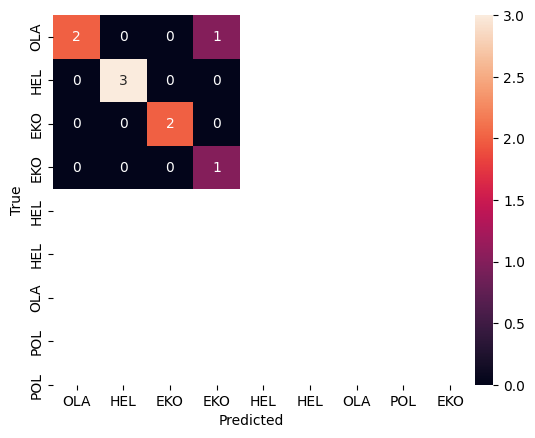

In [55]:
from sklearn.metrics import confusion_matrix



L1 = ['OLA','HEL','EKO','EKO','HEL','HEL','OLA','POL','EKO']
L2 = ['OLA','HEL','EKO','EKO','HEL','HEL','OLA','POL','POL']


conf_matrix = confusion_matrix(L1, L2)
#conf_matrix = confusion_matrix([2,1,1,1,0,1], [2,1,1,1,0,1])
print(conf_matrix)

sns.heatmap(
    conf_matrix, annot=True,
    xticklabels= L1 ,
    yticklabels= L2)
plt.xlabel("Predicted")
plt.ylabel("True")

Confusion matrix yang diberikan terdiri dari tiga kelas (class), yaitu kelas EKO, KESEHATAN, dan OLAHRAGA. Kolom merepresentasikan nilai prediksi dan baris merepresentasikan nilai sebenarnya. Oleh karena itu, diagonal utama dari matrix menunjukkan jumlah prediksi yang benar.

Berdasarkan confusion matrix yang diberikan, dapat disimpulkan bahwa:

Kelas pertama memiliki dua prediksi yang benar (true positive), sementara tidak ada prediksi yang salah (false positive) atau salah negatif (false negative) pada kelas ini.
Kelas kedua memiliki tiga prediksi yang benar (true positive), sementara tidak ada prediksi yang salah (false positive) atau salah negatif (false negative) pada kelas ini.
Kelas ketiga memiliki satu prediksi yang benar (true positive), sementara tidak ada prediksi yang salah (false positive) atau salah negatif (false negative) pada kelas ini.
Dengan demikian, dapat disimpulkan bahwa model memiliki performa yang cukup baik untuk memprediksi tiga kelas yang ada, karena tidak terdapat nilai false positive atau false negative pada setiap kelasnya

# TABLE PEMBELAJARAN / LEARNING RATE

In [ ]:
LOSS = [0.7776076197624207,0.5466572642326355,0.4511881172657013,0.41121599078178406,0.3235812485218048,0.20382441580295563,0.18509308993816376,0.1851392388343811]
ACCURACY = [0.7973856329917908,0.843137264251709,0.8562091588973999,0.8562091588973999,0.9142857193946838,0.920634925365448,0.9238095283508301,0.9269841313362122]
DATASET_RAW = [1000,1000,1000,1000,1500,1500,1500,1500]
EPOCH = [150,300,450,600,150,300,450,600]

BASIC = pd.DataFrame()
BASIC['EPOCH'] = EPOCH
BASIC['ACCURACY'] = ACCURACY
BASIC['LOSS'] = LOSS
BASIC['DATASET'] = DATASET_RAW


In [ ]:
display(BASIC)

,EPOCH,ACCURACY,LOSS,DATASET
0,150,0.797386,0.777608,1000
1,300,0.843137,0.546657,1000
2,450,0.856209,0.451188,1000
3,600,0.856209,0.411216,1000
4,150,0.914286,0.323581,1500
5,300,0.920635,0.203824,1500
6,450,0.923810,0.185093,1500
7,600,0.926984,0.185139,1500


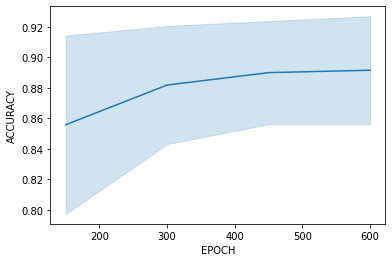

In [ ]:
sns.lineplot(data=BASIC, x="EPOCH", y="ACCURACY")
plt.show()

# Catatan Kesimpulan Sederhana

Dari hasil eksperimen yang diberikan, dapat disimpulkan bahwa:

1. Ukuran dataset yang lebih besar dan jumlah epoch yang lebih banyak cenderung menghasilkan akurasi yang lebih tinggi dan kerugian yang lebih rendah pada model yang dilatih.

2. Nilai akurasi dan kerugian berbanding lurus dan terbalik dengan ukuran dataset dan jumlah epoch, masing-masing.
3. Akurasi tertinggi dan kerugian terendah dicapai dengan menggunakan ukuran dataset terbesar dan jumlah epoch terbanyak.

4. Peningkatan ukuran dataset dan jumlah epoch berdampak positif pada akurasi dan negatif pada loss model.
5. Nilai akurasi dan loss model memiliki korelasi positif dan negatif dengan ukuran dataset dan jumlah epoch, masing-masing.

6. Dalam eksperimen ini, kombinasi ukuran dataset terbesar dan jumlah epoch terbanyak menghasilkan nilai akurasi tertinggi dan nilai loss terendah.

Temuan ini sejalan dengan praktik umum dalam machine learning, di mana ukuran dataset yang lebih besar dan lebih banyak epoch pelatihan umumnya menghasilkan performa model yang lebih baik.